4.758620689655173
6
69


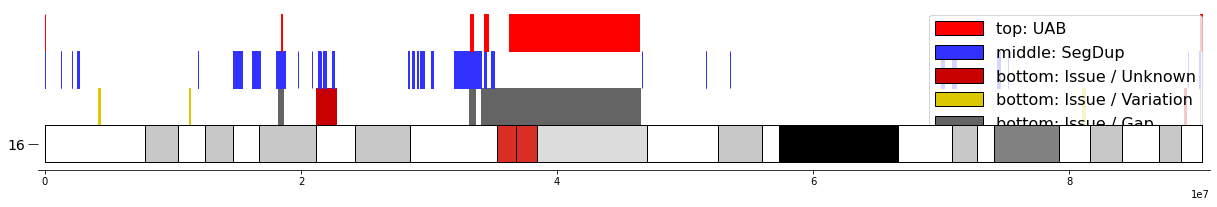

In [39]:
import pandas as pd
import os
import re

import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt

# http://circos.ca/tutorials/lessons/2d_tracks/connectors/configuration

path = '/home/local/work/code/github/project-diploid-assembly/annotation/grch38'
issues = os.path.join(path, '20200723_GRCh38_p13_unresolved-issues.bed')
segdups = os.path.join(path, 'GRCh38_segdups.bed')

path2 = '/home/local/work/code/github/project-diploid-assembly/scripts'
lowq = os.path.join(path2, 'lowQ_1-22-X_all_all.bed')
hiq = os.path.join(path2, 'highQ_1-22-X_all_all.bed')
breaks = os.path.join(path2, 'breaks_1-22-X_all_all.bed')


region_colors = {
    'Gap': tuple([round(x/255, 3) for x in [100, 100, 100]]),
    'Variation': tuple([round(x/255, 3) for x in [220, 200, 0]]),
    'Unknown': tuple([round(x/255, 3) for x in [200, 0, 0]]),
    'highQ': tuple([round(x/255, 3) for x in [0, 155, 255]]),
    'lowQ': tuple([round(x/255, 3) for x in [255, 155, 0]]),
    'SegDup': tuple([round(x/255, 3) for x in [50, 50, 255]]),
    'UAB': tuple([round(x/255, 3) for x in [255, 0, 0]]),
}

def load_annotation(file_path, color=None):
    
    df = pd.read_csv(file_path, sep='\t')
    if 'Issue_Type' in df:
        df['color'] = df['Issue_Type'].apply(lambda x: region_colors[x])
    elif 'chromStart' in df:
        df['color'] = df['chromStart'].apply(lambda x: color)
    else:
        df['color'] = df['start'].apply(lambda x: color)
    if 'end' in df:
        df['length'] = df['end'] - df['start']
    if 'chromEnd' in df:
        df['length'] = df['chromEnd'] - df['chromStart']
        df['start'] = df['chromStart']
        df['end'] = df['chromEnd']
        df = df.loc[(df['score'] > 980), :].copy()
    if '#chrom' in df:
        df['chrom'] = df['#chrom']
    return df
    
annotations = [
    (load_annotation(issues), 'Issues'),
    (load_annotation(lowq, region_colors['lowQ']), 'lowQ'),
    (load_annotation(hiq, region_colors['highQ']), 'highQ')
]

annotations = [
    (load_annotation(issues), 'Issues'),
    (load_annotation(segdups, region_colors['SegDup']), 'SegDup'),
    (load_annotation(breaks, region_colors['UAB']), 'UAB')
]

gie_stain_rgb = {
    'gpos100': (0,0,0),
    'gpos': (0,0,0),
    'gpos75': (130,130,130),
    'gpos66': (160,160,160),
    'gpos50': (200,200,200),
    'gpos33': (210,210,210),
    'gpos25': (200,200,200),
    'gvar': (220,220,220),
    'gneg': (255,255,255),
    'acen': (217,47,39),
    'stalk': (100,127,164)
}


gie_stain_frac_rgb = {}
for k, v in gie_stain_rgb.items():
    frac_rgb = tuple([round(x/255, 3) for x in v])
    gie_stain_frac_rgb[k] = frac_rgb

path = '/home/local/work/code/github/project-diploid-assembly/annotation/grch38/known_regions'
cytobands = 'ucsc_cytoband.bed'

df = pd.read_csv(
    os.path.join(path, cytobands),
    header=0,
    names=['chrom', 'start', 'end', 'name', 'gieStain'],
    sep='\t'
)
df['length'] = df['end'] - df['start']
df['color'] = df['gieStain'].apply(lambda x: gie_stain_frac_rgb[x])

width = 21
height = 3

print(138 / 29)

fig, ax = plt.subplots(figsize=(width, height))

y_start = 0
primary_chroms = ['chr' + str(i) for i in range(1, 23)] + ['chrX']
primary_chroms = ['chr16']
y_labels = []
y_label_pos = []
legend_patches = []
max_plot = 0
for c in reversed(primary_chroms):
    y_labels.append(c.strip('chr'))
    y_label_pos.append(y_start + 0.5)
    barh_xranges = []
    barh_colors = []
    for idx, band in df.loc[df['chrom'] == c, :].iterrows():
        x_min = band['start']
        x_width = band['length']
        x_max = x_min + x_width
        max_plot = max(max_plot, x_max)
        barh_xranges.append((x_min, x_width))
        barh_colors.append(band['color'])

    ax.broken_barh(
        barh_xranges,
        (y_start, 1),
        edgecolor='black',
        facecolors=barh_colors,
        zorder=10
    )
    y_start += 1
    for level, (ann, ann_label) in enumerate(annotations, start=1):
        literal = {1: 'bottom', 2: 'middle', 3: 'top', 4: 'IV', 5: 'V'}[level]
        
        barh_xranges = []
        barh_colors = []
        for idx, region in ann.loc[ann['chrom'] == c, :].iterrows():
            x_min = region['start']
            x_width = region['length']
            barh_xranges.append((x_min, x_width))
            barh_colors.append(region['color'])
        
        if c == primary_chroms[0]:            
            if ann_label == 'Issues':
                for issue_type in ['Gap', 'Variation', 'Unknown']:
                    p = patches.Patch(
                            facecolor=region_colors[issue_type],
                            edgecolor='black',
                            label='{}: Issue / {}'.format(literal, issue_type)
                        )
                    legend_patches.append(p)
            else:
                p = patches.Patch(
                        facecolor=region_colors[ann_label],
                        edgecolor='black',
                        label='{}: {}'.format(literal, ann_label)
                    )
                legend_patches.append(p)
            
        ax.broken_barh(
            barh_xranges,
            (y_start, 1),
            edgecolor='face',
            facecolors=barh_colors
        )
        y_start += 1
    y_start += 2

# build custom legend
ax.legend(
    handles=list(reversed(legend_patches)),
    loc='best',
    handlelength=3,
    handleheight=1,
    prop={'size': 16}
)
    
print(y_start)
print(23 * 3)
_ = ax.set_yticks(y_label_pos)
_ = ax.set_yticklabels(y_labels, fontsize=14)
#_ = ax.set_xticklabels([])
#_ = ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', which='major', length=10)

_ = ax.set_xlim(-500000, max_plot // 1e6 * 1e6 + 1e6)